In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
from scipy import stats
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import time

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import folium
import fbprophet
plt.style.use('fivethirtyeight')
#import pickle
import gc
import warnings
warnings.filterwarnings('ignore')


D:\AnacondaIDE\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import itertools

D:\AnacondaIDE\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train = pd.read_csv('D:/ML work/Zillow Home Value Prediction/train_2016_v2/train_2016_v2.csv')
properties = pd.read_csv('D:/ML work/Zillow Home Value Prediction/properties_2016/properties_2016.csv', chunksize = 1000000)

In [4]:
properties_df = pd.DataFrame()

# Joining the chunks of properties csv data

In [5]:
for chunk in properties:
    properties_df = properties_df.append(chunk, ignore_index = True)
    

# Shape of train and properties_df

In [6]:
train.shape

(90275, 3)

In [7]:
properties_df.shape

(2985217, 58)

# Convert train DF's transactiondate field to datetime

In [8]:
train['transactiondate'] = pd.to_datetime(train['transactiondate'], format = '%Y-%m-%d')

# Merge the properties and train

In [9]:
properties_df = properties_df.merge(train, how = 'left', on = 'parcelid')

# Shape of properties after merge

In [10]:
properties_df.shape

(2985342, 60)

# Now we dont need train DF

In [11]:
## So better delete it to save memory

In [12]:
del chunk, properties, train
gc.collect()

277

# Now convert 64 bit types to 32 bits to save memory

In [13]:
for c, dtype in zip(properties_df.columns, properties_df.dtypes):
    if dtype == np.float64:
        properties_df[c] = properties_df[c].astype(np.float32) 
    elif dtype == np.int64:
        properties_df[c] = properties_df[c].astype(np.int32)
#end for loop

In [14]:
gc.collect()

212

# Datatypes count

In [15]:
properties_df.get_dtype_counts()

datetime64[ns]     1
float32           53
int32              1
object             5
dtype: int64

# Mean, Median and Standard Deviation of logerror

In [16]:
error_mean = np.mean(properties_df['logerror'])
error_median = np.median(properties_df['logerror'].dropna())
error_std = np.std(properties_df['logerror'])

error_mean


0.01145784743130207

In [17]:
error_median

0.0060000001

In [18]:
error_std

0.16107094287872314

# No. of records of columns

In [19]:
properties_df.count()

parcelid                        2985342
airconditioningtypeid            811552
architecturalstyletypeid           6062
basementsqft                       1628
bathroomcnt                     2973880
bedroomcnt                      2973892
buildingclasstypeid               12629
buildingqualitytypeid           1938568
calculatedbathnbr               2856424
decktypeid                        17096
finishedfloor1squarefeet         202723
calculatedfinishedsquarefeet    2929774
finishedsquarefeet12            2709295
finishedsquarefeet13               7672
finishedsquarefeet15             190807
finishedsquarefeet50             202723
finishedsquarefeet6               22003
fips                            2973905
fireplacecnt                     312647
fullbathcnt                     2856424
garagecarcnt                     883307
garagetotalsqft                  883307
hashottuborspa                    69016
heatingorsystemtypeid           1806476
latitude                        2973905


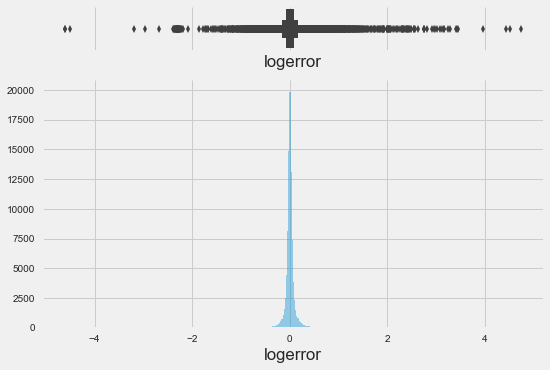

In [20]:
# visualize the log error
log_error = properties_df['logerror'].dropna()

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True , gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(log_error, ax = ax_box)
sns.distplot(log_error, ax = ax_hist, bins = 400, kde = False)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
#plt.xlim([me-2*st, me+2*st])
plt.show()

In [21]:
properties_df['abs_logerror'] = properties_df['logerror'].abs()

In [22]:
properties_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,abs_logerror
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,1413387.0,2015.0,762631.0,20800.369141,NaN,NaN,NaN,NaN,NaT,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1156834.0,2015.0,585488.0,14557.570312,NaN,NaN,NaN,NaN,NaT,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,433491.0,2015.0,239695.0,5725.169922,NaN,NaN,NaN,NaN,NaT,NaN


# TransactionMonth Vs Abs_logerror

In [23]:
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show

In [24]:
fips1 = pd.DataFrame(properties_df.loc[properties_df['fips']==6037].groupby('transactiondate')['abs_logerror'].mean())
fips1.reset_index(inplace = True)
fips2 = pd.DataFrame(properties_df.loc[properties_df['fips']==6059].groupby('transactiondate')['abs_logerror'].mean())
fips2.reset_index(inplace = True)
fips3 = pd.DataFrame(properties_df.loc[properties_df['fips']==6111].groupby('transactiondate')['abs_logerror'].mean())
fips3.reset_index(inplace = True)


output_notebook()
out = figure(plot_width=800, plot_height=250, x_axis_type="datetime")

for data, name, color in zip([fips1, fips2, fips3], ["Los Angeles", "Orange County", "Ventura County"], Spectral4):
    
    out.line(data['transactiondate'], data['abs_logerror'], line_width=2, color=color, alpha=0.8, legend=name)

out.legend.location = "top_left"
out.legend.click_policy="hide"
show(out)

Loading BokehJS ...

# YearBuilt vs Abs-logerror

In [25]:
#yearbuilt
fips1 = pd.DataFrame(properties_df.loc[properties_df['fips']==6037].groupby('yearbuilt')['abs_logerror'].mean())
fips1.reset_index(inplace = True)
fips2 = pd.DataFrame(properties_df.loc[properties_df['fips']==6059].groupby('yearbuilt')['abs_logerror'].mean())
fips2.reset_index(inplace = True)
fips3 = pd.DataFrame(properties_df.loc[properties_df['fips']==6111].groupby('yearbuilt')['abs_logerror'].mean())
fips3.reset_index(inplace = True)

output_notebook()
out = figure(plot_width=800, plot_height=250)

for data, name, color in zip([fips1, fips2, fips3], ["Los Angeles", "Orange County", "Ventura County"], Spectral4):

    out.line(data['yearbuilt'], data['abs_logerror'], line_width=2, color=color, alpha=0.8, legend=name)

out.legend.location = "top_right"
out.legend.click_policy="hide"
show(out)

Loading BokehJS ...

In [26]:
del fips1, fips2, fips3
gc.collect()

248

In [27]:
import plotly # visualization
from plotly.graph_objs import Scatter, Figure, Layout # visualization
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot # visualization
import plotly.figure_factory as ff # visualization
import plotly.graph_objs as go # visualization
init_notebook_mode(connected=True) # visualization

worst_prediction = properties_df['abs_logerror'].quantile(q=.95)


trace0 = go.Scatter(
    y = properties_df[(properties_df['fips']==6037)&(properties_df['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean(),
    x = properties_df[(properties_df['fips']==6037)&(properties_df['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Los Angeles", 
)
trace1 = go.Scatter(
    y = properties_df[(properties_df['fips']==6059)&(properties_df['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean(),
    x = properties_df[(properties_df['fips']==6059)&(properties_df['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Orange County"
)
trace2 = go.Scatter(
    y = properties_df[(properties_df['fips']==6111)&(properties_df['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean(),
    x = properties_df[(properties_df['fips']==6111)&(properties_df['abs_logerror']>worst_prediction)].\
                groupby('yearbuilt')['abs_logerror'].mean().index,
    mode = 'lines+markers',
    name = "Ventura County"
)
data = [trace0, trace1, trace2]

plotly.offline.iplot(data, filename='line-mode')

# Geospatial analysis

In [28]:
geo_df = properties_df[['latitude', 'longitude','logerror']]

In [29]:
geo_df['longitude']/=1e6
geo_df['latitude']/=1e6

In [30]:
geo_df.count()

latitude     2973905
longitude    2973905
logerror       90275
dtype: int64

In [31]:
geo_df.dropna(subset=['latitude','longitude'], axis=0 ,inplace=True)

In [32]:
geo_df.count()

latitude     2973905
longitude    2973905
logerror       90275
dtype: int64

In [33]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=120, batch_size=1000).fit(geo_df[['latitude','longitude']])
geo_df.loc[:, 'label'] = kmeans.labels_

In [34]:
map_2 = folium.Map(location=[34.088537, -118.249923],
                   zoom_start=9)
for label in kmeans.cluster_centers_:
    folium.Marker(location=[label][0]).add_to(map_2)

In [35]:
map_2


In [36]:
map_1 = folium.Map(location=[34.088537, -118.249923], zoom_start=9,
                   tiles='Stamen Terrain')
for label in kmeans.cluster_centers_:
    folium.Marker(location=[label][0]).add_to(map_1)

In [37]:
map_1


In [38]:
del map_1, map_2


In [39]:
gc.collect()

5

# The areas with perfect estimations

In [40]:
perfect_geo_df = geo_df[geo_df['logerror'] == 0]
perfect_geo_df.shape

(847, 4)

In [41]:
map_perfect = folium.Map(location=[34.088537, -118.249923], zoom_start=9,
                   tiles='Stamen Toner')
for lat, lon in zip(perfect_geo_df.latitude, perfect_geo_df.longitude):
    folium.Marker(location=[lat,lon]).add_to(map_perfect)
map_perfect

In [42]:
del perfect_geo_df, map_perfect, geo_df
gc.collect()

46

# Time Series analysis

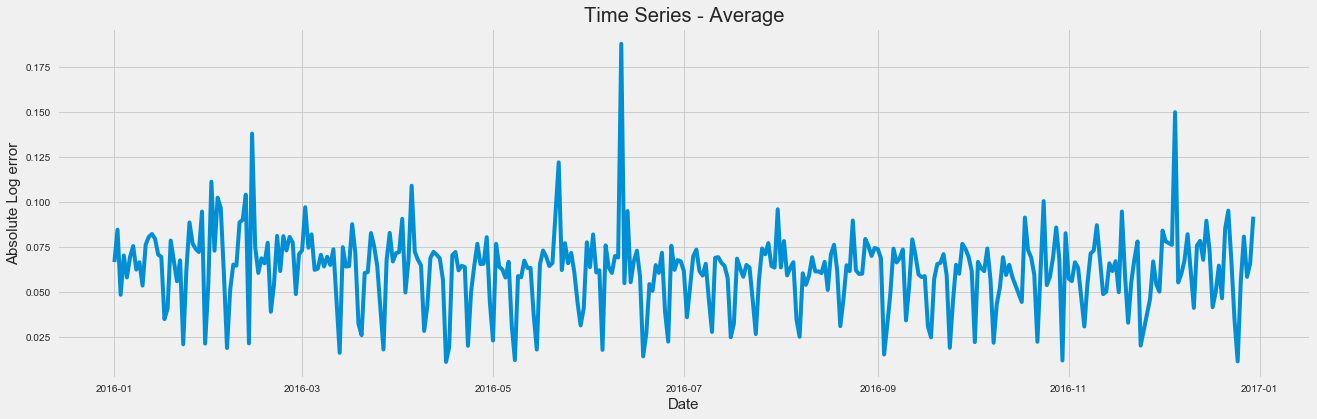

In [43]:
plt.figure(figsize=(20, 6))
mean_group = properties_df[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].mean()
plt.plot(mean_group)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - Average')
plt.show()

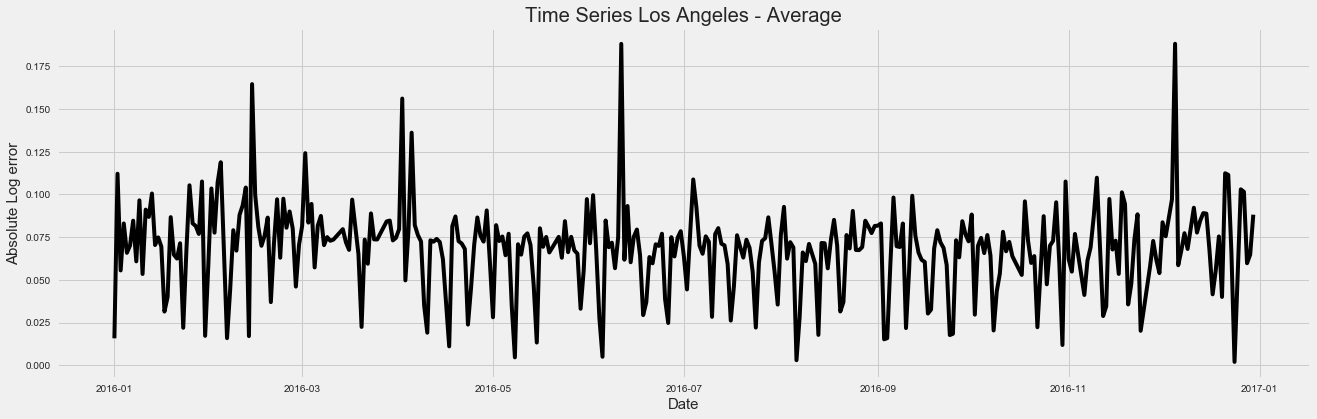

In [44]:
plt.figure(figsize=(20, 6)) 
fips1 = pd.DataFrame(properties_df.loc[properties_df['fips']==6037].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1,c='k')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series Los Angeles - Average')
plt.show()

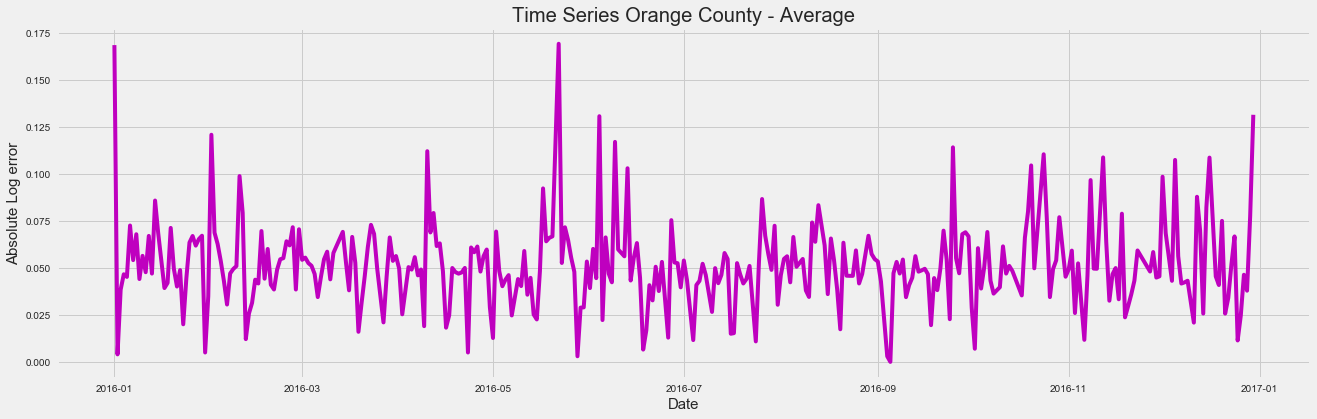

In [45]:
plt.figure(figsize=(20, 6)) 
fips1 = pd.DataFrame(properties_df.loc[properties_df['fips']==6059].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1, c = 'm')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series Orange County - Average')
plt.show()

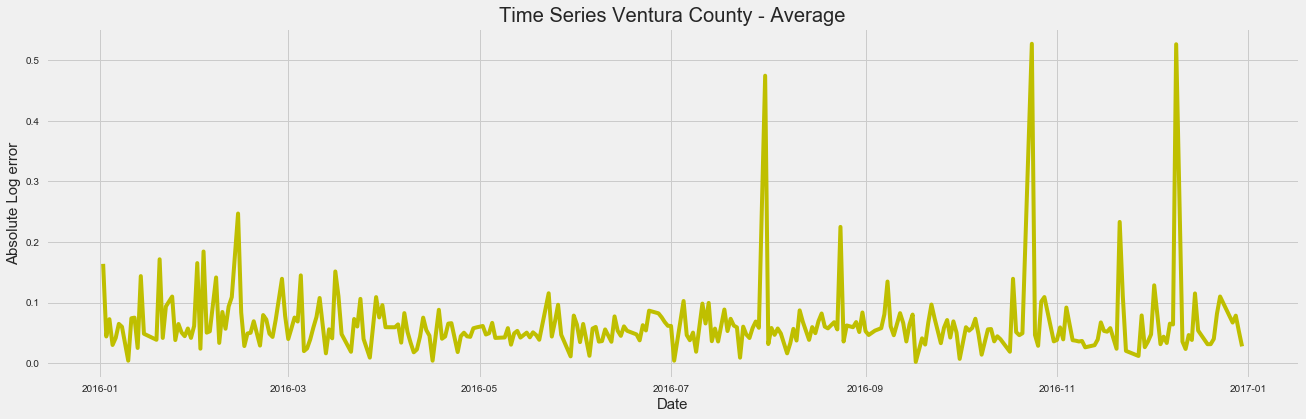

In [46]:
plt.figure(figsize=(20, 6))
fips1 = pd.DataFrame(properties_df.loc[properties_df['fips']==6111].groupby('transactiondate')['abs_logerror'].mean())
plt.plot(fips1, c = 'y')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series Ventura County - Average')
plt.show()

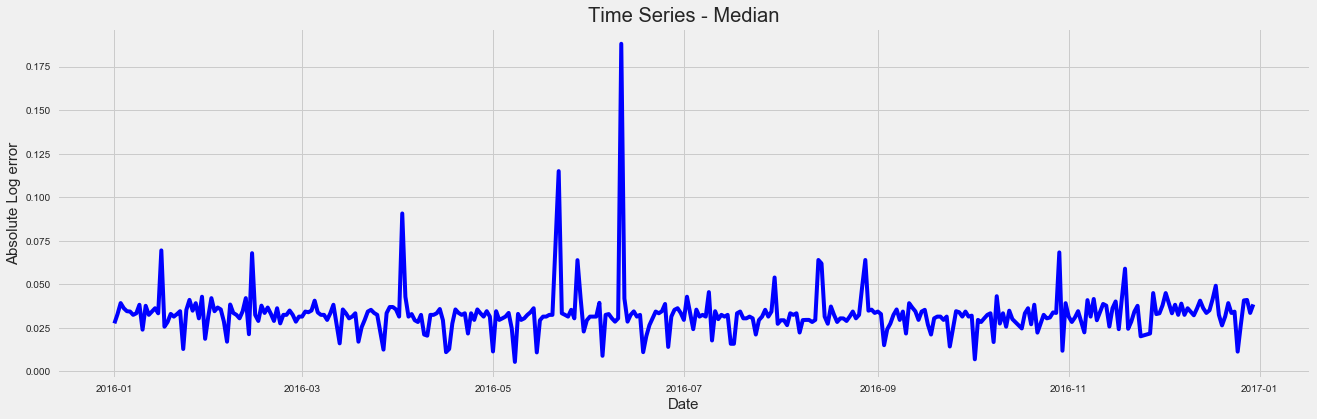

In [47]:
plt.figure(figsize=(20, 6))
median_group = properties_df[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].median()
plt.plot(median_group, c='b')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - Median')
plt.show()

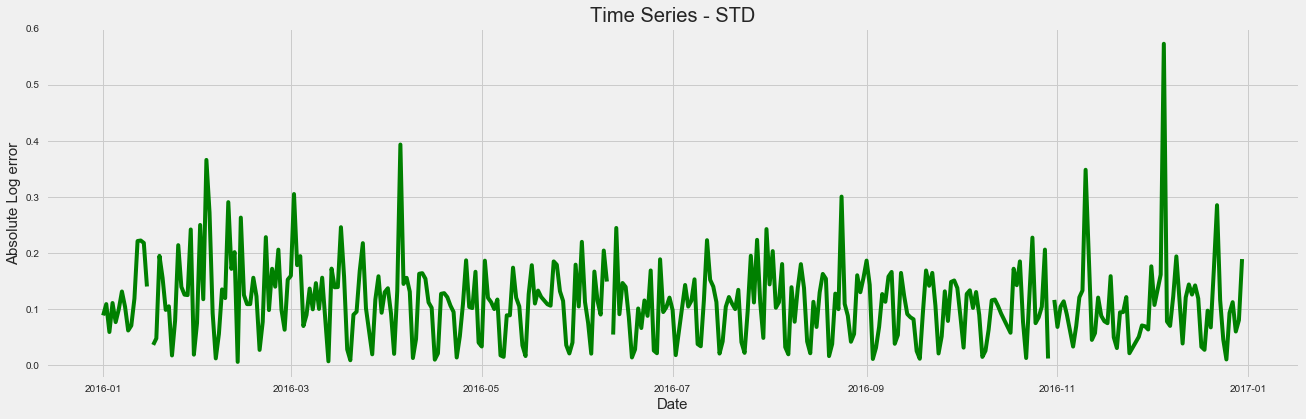

In [48]:
plt.figure(figsize=(20, 6))
std_group = properties_df[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].std()
plt.plot(std_group, c='g')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Absolute Log error', fontsize=15)
plt.title('Time Series - STD')
plt.show()

In [49]:
del mean_group, median_group, std_group
gc.collect()

30094

In [50]:
properties_df_inliner = properties_df[properties_df['abs_logerror'] <  error_mean + error_std ]

In [51]:
mean_group = properties_df_inliner[['transactiondate','abs_logerror']].groupby(['transactiondate'])['abs_logerror'].mean()

In [52]:
mean_group.shape

(351,)

In [53]:
mean_group

transactiondate
2016-01-01    0.066667
2016-01-02    0.047520
2016-01-03    0.041635
2016-01-04    0.044059
2016-01-05    0.042781
2016-01-06    0.042160
2016-01-07    0.041163
2016-01-08    0.040238
2016-01-09    0.044350
2016-01-10    0.040122
2016-01-11    0.039377
2016-01-12    0.041835
2016-01-13    0.042022
2016-01-14    0.041928
2016-01-15    0.042223
2016-01-16    0.069500
2016-01-17    0.034922
2016-01-18    0.033670
2016-01-19    0.041966
2016-01-20    0.041227
2016-01-21    0.040439
2016-01-22    0.041365
2016-01-23    0.020878
2016-01-24    0.043117
2016-01-25    0.045714
2016-01-26    0.040852
2016-01-27    0.044950
2016-01-28    0.040281
2016-01-29    0.045920
2016-01-30    0.021283
                ...   
2016-11-29    0.039430
2016-11-30    0.038989
2016-12-01    0.045396
2016-12-02    0.048960
2016-12-04    0.030992
2016-12-05    0.041142
2016-12-06    0.039004
2016-12-07    0.047385
2016-12-08    0.041471
2016-12-09    0.039357
2016-12-11    0.041158
2016-12-12    0.03

# Time Series Components

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. These components are defined as follows:

Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.

# Combining Time Series Components

A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonality components are optional. It is helpful to think of the components as combining either additively or multiplicatively.

Additive Model y(t) = Level + Trend + Seasonality + Noise

Multiplicative Model y(t) = Level x Trend x Seasonality x Noise

# Additive Model:

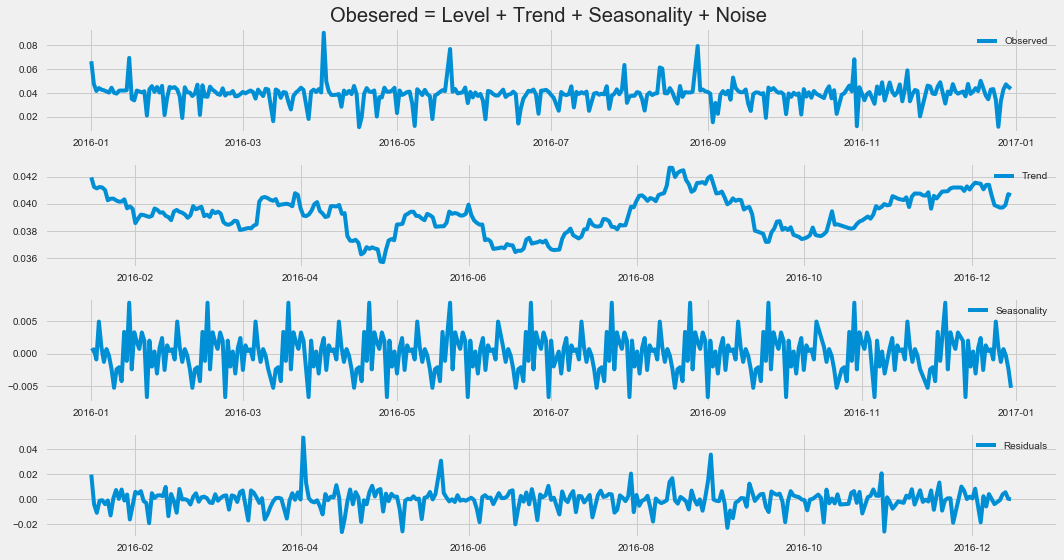

In [54]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
df_date_index = times_series_means[['transactiondate','abs_logerror']].set_index('transactiondate')
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='additive',freq = 31)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 15, 8

plt.subplot(411)
plt.title('Obesered = Level + Trend + Seasonality + Noise ')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Multiplication Model:

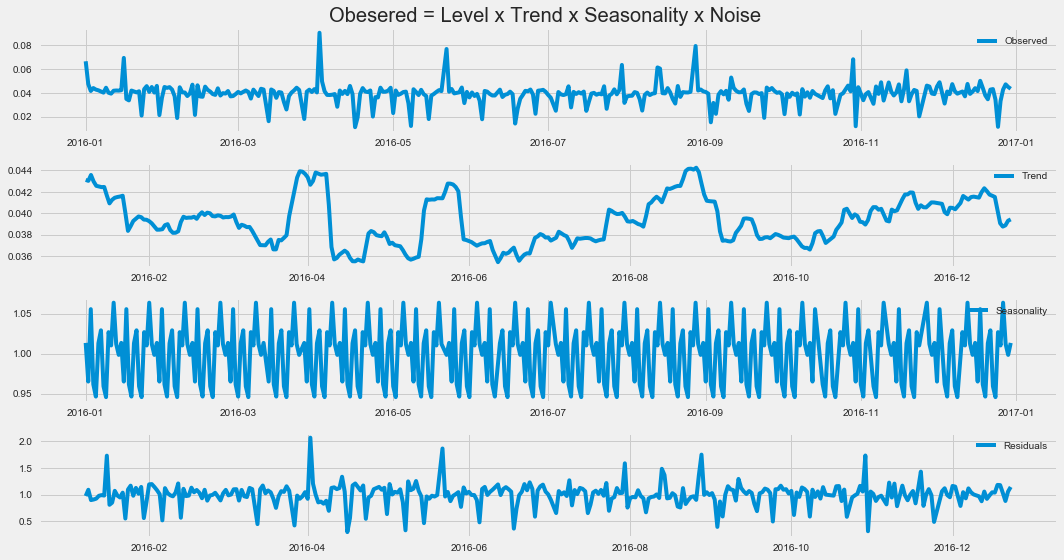

In [55]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
df_date_index = times_series_means[['transactiondate','abs_logerror']].set_index('transactiondate')
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative',freq = 14)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 15, 8

plt.subplot(411)
plt.title('Obesered = Level x Trend x Seasonality x Noise ')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Moving Average Smoothing / Random Walk and Stationarity¶
Moving average smoothing is a naive and effective technique in time series forecasting. It can be used for data preparation, feature engineering, and even directly for making predictions.

A stationary time series is one where the values are not a function of time. We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

The script is copied from kaggler

Julien Heiduk and

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

Dr. Jason Brownlee

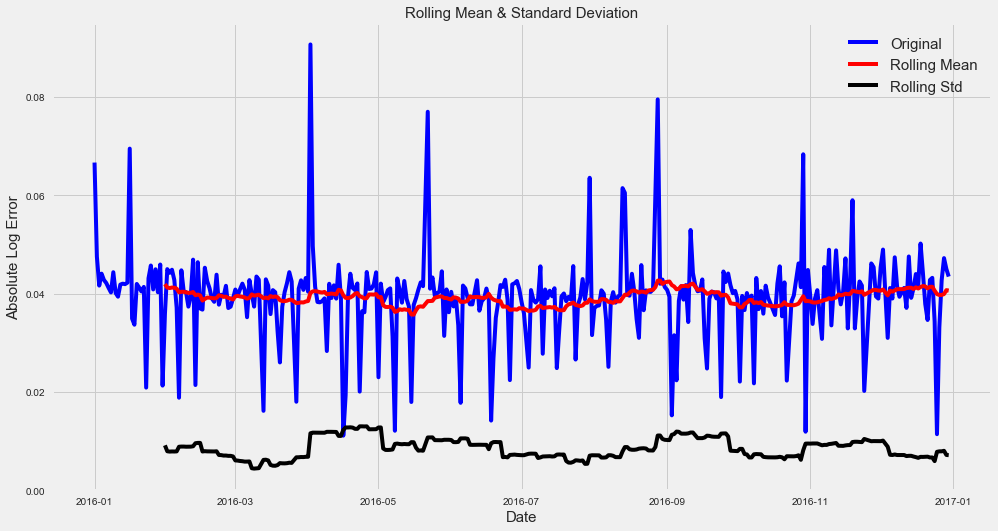

Results of Dickey-Fuller Test:
Test Statistic                -1.736474e+01
p-value                        5.179029e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


In [56]:
def test_stationarity(timeseries):
    plt.figure(figsize=(15, 8))
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=31) # Slide window depend on past 1 month
    rolstd = pd.rolling_std(timeseries, window=31)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best', fontsize=15)
    plt.title('Rolling Mean & Standard Deviation', fontsize=15)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Absolute Log Error', fontsize=15)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['abs_logerror'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index)  

https://machinelearningmastery.com/time-series-data-stationary-python/

https://www.otexts.org/fpp/6/1

In [57]:
# test Statistics value greater than all critical values accepts the null hypothesis and hence non-stationary time series

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


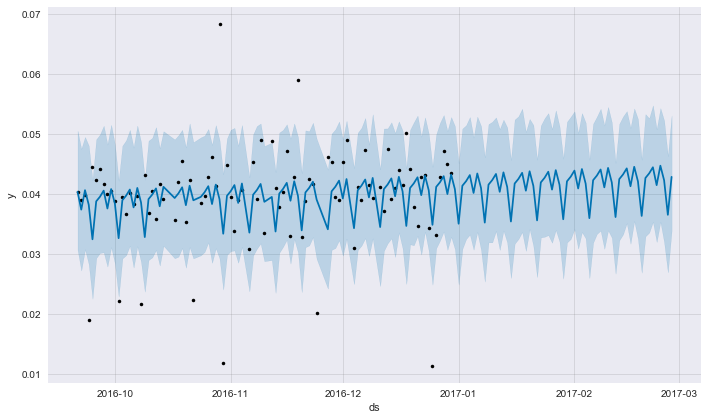

In [58]:
sns.set(font_scale=1) 
df_prophet =  pd.DataFrame(mean_group).reset_index(drop=False)
df_prophet = df_prophet.iloc[-92:,:] # Forecast due to past 3 months
df_prophet.columns = ['ds','y']

m = fbprophet.Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=59,freq='D') # Forecast Jan 2017
forecast = m.predict(future)
plt.figure(figsize=(30, 6))
fig = m.plot(forecast)
plt.show()

# Analyzing co-relation of attributes

In [59]:
from matplotlib import cm

In [60]:
properties_df.columns.values.tolist()

['parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'firep

In [61]:
properties_df.isnull().sum()

parcelid                              0
airconditioningtypeid           2173790
architecturalstyletypeid        2979280
basementsqft                    2983714
bathroomcnt                       11462
bedroomcnt                        11450
buildingclasstypeid             2972713
buildingqualitytypeid           1046774
calculatedbathnbr                128918
decktypeid                      2968246
finishedfloor1squarefeet        2782619
calculatedfinishedsquarefeet      55568
finishedsquarefeet12             276047
finishedsquarefeet13            2977670
finishedsquarefeet15            2794535
finishedsquarefeet50            2782619
finishedsquarefeet6             2963339
fips                              11437
fireplacecnt                    2672695
fullbathcnt                      128918
garagecarcnt                    2102035
garagetotalsqft                 2102035
hashottuborspa                  2916326
heatingorsystemtypeid           1178866
latitude                          11437


In [62]:
properties_df['pooltypeid2'].isnull().sum()

2953267

In [63]:
# bathroomcnt and calculatedbathnbr are redundant and highly positively correlated but previous one has more null entries

In [64]:
# finishedsquarefeet50 and finishedfloor1squarefeet are also redundant

In [65]:
# First we copy non-null values of bathroomcnt to null values of calculatedbathnbr and then remove batroomcnt

In [66]:
#Check if bathroomcnt contains non-null values where calculatedbathnbr are null
properties_df[properties_df['bathroomcnt'].notnull()]['calculatedbathnbr']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         2.0
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         4.0
27         NaN
28         2.0
29         4.0
          ... 
2973875    3.0
2973876    NaN
2973877    2.5
2973878    3.0
2973879    NaN
2973880    NaN
2973881    2.5
2973882    2.0
2973883    NaN
2973884    3.0
2973885    3.0
2973886    3.0
2973887    NaN
2973888    2.0
2973889    NaN
2973890    2.5
2973891    NaN
2973892    3.0
2973893    NaN
2973894    3.0
2973895    3.5
2973896    2.0
2973897    3.0
2973898    NaN
2973899    6.0
2973900    1.0
2973901    3.0
2973902    4.0
2973903    1.0
2973904    NaN
Name: calculatedbathnbr, Length: 2973880, dtype: float32

In [67]:
properties_df['calculatedbathnbr'] = np.where(np.isnan(properties_df['calculatedbathnbr']), properties_df['bathroomcnt'], properties_df['calculatedbathnbr'])

In [68]:
# so these are replaced
properties_df[properties_df['bathroomcnt'].notnull()]['calculatedbathnbr']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
5          0.0
6          0.0
7          0.0
8          0.0
9          0.0
10         0.0
11         0.0
12         0.0
13         0.0
14         0.0
15         0.0
16         0.0
17         0.0
18         0.0
19         2.0
20         0.0
21         0.0
22         0.0
23         0.0
24         0.0
25         0.0
26         4.0
27         0.0
28         2.0
29         4.0
          ... 
2973875    3.0
2973876    0.0
2973877    2.5
2973878    3.0
2973879    0.0
2973880    0.0
2973881    2.5
2973882    2.0
2973883    0.0
2973884    3.0
2973885    3.0
2973886    3.0
2973887    0.0
2973888    2.0
2973889    0.0
2973890    2.5
2973891    0.0
2973892    3.0
2973893    0.0
2973894    3.0
2973895    3.5
2973896    2.0
2973897    3.0
2973898    0.0
2973899    6.0
2973900    1.0
2973901    3.0
2973902    4.0
2973903    1.0
2973904    0.0
Name: calculatedbathnbr, Length: 2973880, dtype: float32

In [69]:
#drop bathroomcnt
properties_df.drop('bathroomcnt', axis = 1, inplace = True)

In [70]:
df1 = properties_df['finishedsquarefeet50']
df2 = properties_df['finishedfloor1squarefeet']


In [71]:
#check null rows in both columns are equal
all(df1.isnull() == df2.isnull())

True

In [72]:
#check non-null rows in both columns are equal
all(df1.notnull() == df2.notnull())

True

In [73]:
# So we can safely drop one column of them
properties_df.drop('finishedsquarefeet50', axis = 1, inplace = True)

In [74]:
#Now analyze fireplacecnt and fireplaceflag to recover fireplaceflag
df1 = properties_df['fireplacecnt']
df2 = properties_df['fireplaceflag']

In [75]:
all(df1.isnull() == df2.isnull())

False

In [76]:
all(properties_df[properties_df['fireplacecnt'].notnull()]['fireplaceflag'].isnull())

True

In [77]:
# if condition is satisfied then replace with True else False
# assume that if fireplacecnt is null, then fireplaceflg will be false
properties_df['fireplaceflag'] = np.where(pd.isnull(properties_df['fireplaceflag']) & pd.notnull(properties_df['fireplacecnt']) & properties_df['fireplacecnt'] > 0, True, False)

In [78]:
properties_df['fireplaceflag'].count()
# fireplaceflag is recovered

2985342

In [79]:
index = properties_df['fireplacecnt'].isnull()
properties_df.loc[index, 'fireplacecnt'] = 0

In [80]:
properties_df['house_age'] = datetime.now().date().year - properties_df['yearbuilt']

In [81]:
properties_df['house_age'].dropna()

3           69.0
4           70.0
5           74.0
7           71.0
9           39.0
10          59.0
17          68.0
18          61.0
19          12.0
20          60.0
22          78.0
23          91.0
24          79.0
26          45.0
27          62.0
28          13.0
29           6.0
30          62.0
31          91.0
33          59.0
34          88.0
35           7.0
38          68.0
39          83.0
40          92.0
42          81.0
43          60.0
46          97.0
47          80.0
48          55.0
           ...  
2973864      3.0
2973865      2.0
2973867      4.0
2973868     54.0
2973869      3.0
2973870     94.0
2973871      4.0
2973872      4.0
2973873      4.0
2973875      4.0
2973877      4.0
2973878      4.0
2973881      4.0
2973882     71.0
2973884      3.0
2973885      3.0
2973886      3.0
2973887     75.0
2973888     62.0
2973890      5.0
2973892      3.0
2973894      3.0
2973895      3.0
2973896      3.0
2973897      3.0
2973899      5.0
2973900     11.0
2973901      3

In [82]:
del df1, df2
#correlation_matrix = properties_df.corr(method = 'pearson')

In [83]:
#f, ax = plt.subplots(figsize=(12, 12))

#sns.heatmap(correlation_matrix, mask=np.zeros_like(correlation_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, linewidths = 0.5, vmin = -1, vmax = 1)
#plt.show()

In [84]:
properties_df.count()

parcelid                        2985342
airconditioningtypeid            811552
architecturalstyletypeid           6062
basementsqft                       1628
bedroomcnt                      2973892
buildingclasstypeid               12629
buildingqualitytypeid           1938568
calculatedbathnbr               2973880
decktypeid                        17096
finishedfloor1squarefeet         202723
calculatedfinishedsquarefeet    2929774
finishedsquarefeet12            2709295
finishedsquarefeet13               7672
finishedsquarefeet15             190807
finishedsquarefeet6               22003
fips                            2973905
fireplacecnt                    2985342
fullbathcnt                     2856424
garagecarcnt                     883307
garagetotalsqft                  883307
hashottuborspa                    69016
heatingorsystemtypeid           1806476
latitude                        2973905
longitude                       2973905
lotsizesquarefeet               2709229


In [85]:
#assume if taxdelinquencyflag is null then False (doesn't exist)
index = properties_df['taxdelinquencyflag'].isnull()
properties_df.loc[index, 'taxdelinquencyflag'] = False

In [86]:
properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985342 entries, 0 to 2985341
Data columns (total 60 columns):
parcelid                        int32
airconditioningtypeid           float32
architecturalstyletypeid        float32
basementsqft                    float32
bedroomcnt                      float32
buildingclasstypeid             float32
buildingqualitytypeid           float32
calculatedbathnbr               float32
decktypeid                      float32
finishedfloor1squarefeet        float32
calculatedfinishedsquarefeet    float32
finishedsquarefeet12            float32
finishedsquarefeet13            float32
finishedsquarefeet15            float32
finishedsquarefeet6             float32
fips                            float32
fireplacecnt                    float32
fullbathcnt                     float32
garagecarcnt                    float32
garagetotalsqft                 float32
hashottuborspa                  object
heatingorsystemtypeid           float32
latitude  

In [87]:
#index = properties_df['hashottuborspa'].isnull()
#properties_df.loc[index, 'hashottuborspa'] = False

In [88]:
#hello = properties_df[properties_df.pooltypeid10 != 1]['pooltypeid10']
#hello[hello.notnull()]

In [89]:
properties_df[properties_df['pooltypeid10'].notnull()][['pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'hashottuborspa']]

,pooltypeid10,pooltypeid2,pooltypeid7,hashottuborspa
1340,1.0,NaN,NaN,True
1341,1.0,NaN,NaN,True
1497,1.0,NaN,NaN,True
1691,1.0,NaN,NaN,True
1694,1.0,NaN,NaN,True
1822,1.0,NaN,NaN,True
1883,1.0,NaN,NaN,True
1939,1.0,NaN,NaN,True
1949,1.0,NaN,NaN,True
1975,1.0,NaN,NaN,True


In [90]:
properties_df[properties_df['pooltypeid10'].isnull()][['pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'hashottuborspa']]

,pooltypeid10,pooltypeid2,pooltypeid7,hashottuborspa
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


In [91]:
all(properties_df[properties_df['pooltypeid10'].notnull()][['hashottuborspa']])

True

In [92]:
properties_df[properties_df['pooltypeid10'].notnull()].loc[['hashottuborspa' == False]]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,abs_logerror,house_age


In [93]:
all(properties_df[properties_df['pooltypeid10'].isnull()]['hashottuborspa'].notnull())

False

In [94]:
any(properties_df[properties_df['hashottuborspa'].isnull()]['pooltypeid10'].notnull())

False

In [95]:
# so pooltypeid10 is 1.0 when hashottuborspa is True, hence redundant attributes
properties_df[['pooltypeid10', 'hashottuborspa']].count()

pooltypeid10      36941
hashottuborspa    69016
dtype: int64

In [96]:
properties_df.drop('pooltypeid10', axis = 1, inplace = True)

In [97]:
properties_df[properties_df['pooltypeid2'].notnull()][['pooltypeid2', 'pooltypeid7', 'hashottuborspa']]

,pooltypeid2,pooltypeid7,hashottuborspa
10336,1.0,NaN,True
10366,1.0,NaN,True
10370,1.0,NaN,True
10445,1.0,NaN,True
10450,1.0,NaN,True
10503,1.0,NaN,True
10583,1.0,NaN,True
10657,1.0,NaN,True
10666,1.0,NaN,True
10684,1.0,NaN,True


In [98]:
properties_df[['pooltypeid2', 'hashottuborspa']].count()

pooltypeid2       32075
hashottuborspa    69016
dtype: int64

In [99]:
all(properties_df.loc[properties_df['pooltypeid2'] == 1.0]['hashottuborspa'])

True

In [100]:
# all rows pooltypeid2 with 1.0 should have hashottuborspa with value True. It is already valid

In [101]:
df = properties_df.loc[properties_df['pooltypeid7'] == 1.0]
df[df['hashottuborspa'] == True]


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,abs_logerror,house_age


In [102]:
# all rows containing 1.0 for pooltypeid have NaN for hashottuborspa. It is valid behaviour.

In [103]:
properties_df[['pooltypeid2', 'pooltypeid7', 'poolsizesum', 'poolcnt']].count()

pooltypeid2     32075
pooltypeid7    485484
poolsizesum     27963
poolcnt        517559
dtype: int64

In [104]:
index = (properties_df['hashottuborspa'] == True) & properties_df['poolcnt'] > 0
properties_df.loc[index, 'pooltypeid2'] = 1.0

In [105]:
index = (properties_df['hashottuborspa'].isnull()) & properties_df['poolcnt'] > 0
properties_df.loc[index, 'pooltypeid7'] = 1.0

In [106]:
properties_df[['pooltypeid2', 'pooltypeid7', 'poolsizesum', 'poolcnt']].count()

pooltypeid2     32075
pooltypeid7    485484
poolsizesum     27963
poolcnt        517559
dtype: int64

In [107]:
index = properties_df.hashottuborspa.isnull()
properties_df.loc[index, 'hashottuborspa'] = False

index = properties_df.pooltypeid2.isnull()
properties_df.loc[index,'pooltypeid2'] = 0

index = properties_df.pooltypeid7.isnull()
properties_df.loc[index,'pooltypeid7'] = 0

index = properties_df.poolcnt.isnull()
properties_df.loc[index,'poolcnt'] = 0


In [108]:
index = (properties_df.poolcnt == 0)
properties_df.loc[index, 'poolsizesum'] = 0

In [109]:
properties_df[['pooltypeid2', 'pooltypeid7', 'poolsizesum', 'poolcnt']].count()

pooltypeid2    2985342
pooltypeid7    2985342
poolsizesum    2495746
poolcnt        2985342
dtype: int64

In [110]:
# replace 'Y' with True in taxdelinquencyflag
index = (properties_df.taxdelinquencyflag == 'Y')
properties_df.loc[index,'taxdelinquencyflag'] = True

In [111]:
properties_df['taxdelinquencyflag'] = properties_df.taxdelinquencyflag.astype(np.bool)

In [112]:
properties_df['hashottuborspa'] = properties_df.hashottuborspa.astype(np.bool)

In [113]:
#Null in garage count means there are no garages
index = properties_df.garagecarcnt.isnull()
properties_df.loc[index,'garagecarcnt'] = 0

In [114]:
properties_df.count()

parcelid                        2985342
airconditioningtypeid            811552
architecturalstyletypeid           6062
basementsqft                       1628
bedroomcnt                      2973892
buildingclasstypeid               12629
buildingqualitytypeid           1938568
calculatedbathnbr               2973880
decktypeid                        17096
finishedfloor1squarefeet         202723
calculatedfinishedsquarefeet    2929774
finishedsquarefeet12            2709295
finishedsquarefeet13               7672
finishedsquarefeet15             190807
finishedsquarefeet6               22003
fips                            2973905
fireplacecnt                    2985342
fullbathcnt                     2856424
garagecarcnt                    2985342
garagetotalsqft                  883307
hashottuborspa                  2985342
heatingorsystemtypeid           1806476
latitude                        2973905
longitude                       2973905
lotsizesquarefeet               2709229


In [115]:
#error in calculation of the finished living area of home
properties_df['N-LivingAreaError'] = properties_df['calculatedfinishedsquarefeet'] / properties_df['finishedsquarefeet12']

In [116]:
#proportion of living area
properties_df['N-LivingAreaProp'] = properties_df['calculatedfinishedsquarefeet'] / properties_df['lotsizesquarefeet']
properties_df['N-LivingAreaProp2'] = properties_df['finishedsquarefeet12'] / properties_df['finishedsquarefeet15']

In [117]:
#Amout of extra space
properties_df['N-ExtraSpace'] = properties_df['lotsizesquarefeet'] - properties_df['calculatedfinishedsquarefeet'] 
properties_df['N-ExtraSpace-2'] = properties_df['finishedsquarefeet15'] - properties_df['finishedsquarefeet12']

In [118]:
#Average room size
properties_df['N-AvRoomSize'] = properties_df['calculatedfinishedsquarefeet'] / properties_df['roomcnt']

In [119]:
#Total number of rooms
properties_df['N-TotalRooms'] = properties_df['calculatedbathnbr'] + properties_df['bedroomcnt']

In [120]:
# Number of Extra rooms
properties_df['N-ExtraRooms'] = properties_df['roomcnt'] - properties_df['N-TotalRooms']

In [121]:
#Ratio of the built structure value to land area
properties_df['N-ValueProp'] = properties_df['structuretaxvaluedollarcnt']/properties_df['landtaxvaluedollarcnt']

In [122]:
#Does property have a garage, pool or hot tub and AC?
properties_df['N-GarPoolAC'] = ((properties_df['garagecarcnt']>0) & (properties_df['hashottuborspa']>0) & (properties_df['airconditioningtypeid']!=5))*1

In [123]:
properties_df["N-location"] = properties_df["latitude"] + properties_df["longitude"]
properties_df["N-location-2"] = properties_df["latitude"] * properties_df["longitude"]
properties_df["N-location-2round"] = properties_df["N-location-2"].round(-4)

properties_df["N-latitude-round"] = properties_df["latitude"].round(-4)
properties_df["N-longitude-round"] = properties_df["longitude"].round(-4)

In [124]:
#Ratio of tax of property over parcel
properties_df['N-ValueRatio'] = properties_df['taxvaluedollarcnt'] / properties_df['taxamount']

#TotalTaxScore
properties_df['N-TaxScore'] = properties_df['taxvaluedollarcnt']*properties_df['taxamount']

#polnomials of tax delinquency year
properties_df["N-taxdelinquencyyear-2"] = properties_df["taxdelinquencyyear"] ** 2
properties_df["N-taxdelinquencyyear-3"] = properties_df["taxdelinquencyyear"] ** 3

#Length of time since unpaid taxes
properties_df['N-life'] = 2018 - properties_df['taxdelinquencyyear']

In [125]:
#Number of properties in the zip
zip_count = properties_df['regionidzip'].value_counts().to_dict()
properties_df['N-zip_count'] = properties_df['regionidzip'].map(zip_count)

#Number of properties in the city
city_count = properties_df['regionidcity'].value_counts().to_dict()
properties_df['N-city_count'] = properties_df['regionidcity'].map(city_count)

#Number of properties in the city
region_count = properties_df['regionidcounty'].value_counts().to_dict()
properties_df['N-county_count'] = properties_df['regionidcounty'].map(city_count)

In [126]:
#Indicator whether it has AC or not
properties_df['N-ACInd'] = (properties_df['airconditioningtypeid']!=5)*1

In [127]:
#Indicator whether it has Heating or not 
properties_df['N-HeatInd'] = (properties_df['heatingorsystemtypeid']!=13)*1

In [128]:
#There's 25 different property uses - let's compress them down to 4 categories
#properties_df['N-PropType'] = properties_df.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed", 246 : "Mixed", 247 : "Mixed", 248 : "Mixed", 260 : "Home", 261 : "Home", 262 : "Home", 263 : "Home", 264 : "Home", 265 : "Home", 266 : "Home", 267 : "Home", 268 : "Home", 269 : "Not Built", 270 : "Home", 271 : "Home", 273 : "Home", 274 : "Other", 275 : "Home", 276 : "Home", 279 : "Home", 290 : "Not Built", 291 : "Not Built" })

In [129]:
#One of the EDA kernels indicated that structuretaxvaluedollarcnt was one of the most important features. So let's create some additional variables on that.

In [130]:
#polnomials of the variable
properties_df["N-structuretaxvaluedollarcnt-2"] = properties_df["structuretaxvaluedollarcnt"] ** 2
properties_df["N-structuretaxvaluedollarcnt-3"] = properties_df["structuretaxvaluedollarcnt"] ** 3

#Average structuretaxvaluedollarcnt by city
group = properties_df.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
properties_df['N-Avg-structuretaxvaluedollarcnt'] = properties_df['regionidcity'].map(group)

#Deviation away from average
properties_df['N-Dev-structuretaxvaluedollarcnt'] = abs((properties_df['structuretaxvaluedollarcnt'] - properties_df['N-Avg-structuretaxvaluedollarcnt']))/properties_df['N-Avg-structuretaxvaluedollarcnt']

In [131]:
properties_df.shape

(2985342, 88)

In [132]:
properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985342 entries, 0 to 2985341
Data columns (total 88 columns):
parcelid                            int32
airconditioningtypeid               float32
architecturalstyletypeid            float32
basementsqft                        float32
bedroomcnt                          float32
buildingclasstypeid                 float32
buildingqualitytypeid               float32
calculatedbathnbr                   float32
decktypeid                          float32
finishedfloor1squarefeet            float32
calculatedfinishedsquarefeet        float32
finishedsquarefeet12                float32
finishedsquarefeet13                float32
finishedsquarefeet15                float32
finishedsquarefeet6                 float32
fips                                float32
fireplacecnt                        float32
fullbathcnt                         float32
garagecarcnt                        float32
garagetotalsqft                     float32
hashottub

In [133]:
del index

In [134]:
gc.collect()

346

In [135]:
#properties_df[['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode']] = extra_columns

In [136]:
#properties_df = properties_df.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)

#gc.collect()

In [137]:
#train_y = extra_columns['logerror'].values

#feat_names = properties_df.columns.values

#for c in properties_df.columns:
#    if properties_df[c].dtype == 'object':
#        lbl = LabelEncoder()
#        lbl.fit(list(properties_df[c].values))
#        properties_df[c] = lbl.transform(list(properties_df[c].values))

##import xgboost as xgb
#xgb_params = {
#    'eta': 0.05,
#    'max_depth': 8,
#    'subsample': 0.7,
#    'colsample_bytree': 0.7,
#    'objective': 'reg:linear',
#    'silent': 0,
#    'seed' : 0
#}

#dtrain = xgb.DMatrix(properties_df, label = train_y, feature_names = feat_names, silent = False)
#model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

## plot the important features #
#fig, ax = plt.subplots(figsize=(12,18))

##plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

#importance = model.get_fscore()
##importance = sorted(importance.items(), key=operator.itemgetter(1))

#df = pd.DataFrame(importance, columns=['feature', 'fscore'])

#df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
#plt.title('XGBoost Feature Importance')
#plt.xlabel('relative importance')

##xgb.plot_importance(model, max_num_features=70, height=0.8, ax=ax)
#plt.show()

In [138]:
#from pandas.tools.plotting import lag_plot

#lag_plot(timeseries.dropna())
#plt.show()

In [139]:
#timeseries = properties_df[['transactiondate', 'logerror']]

#from pandas.tools.plotting import autocorrelation_plot
#autocorrelation_plot(timeseries.dropna())
#plt.show()

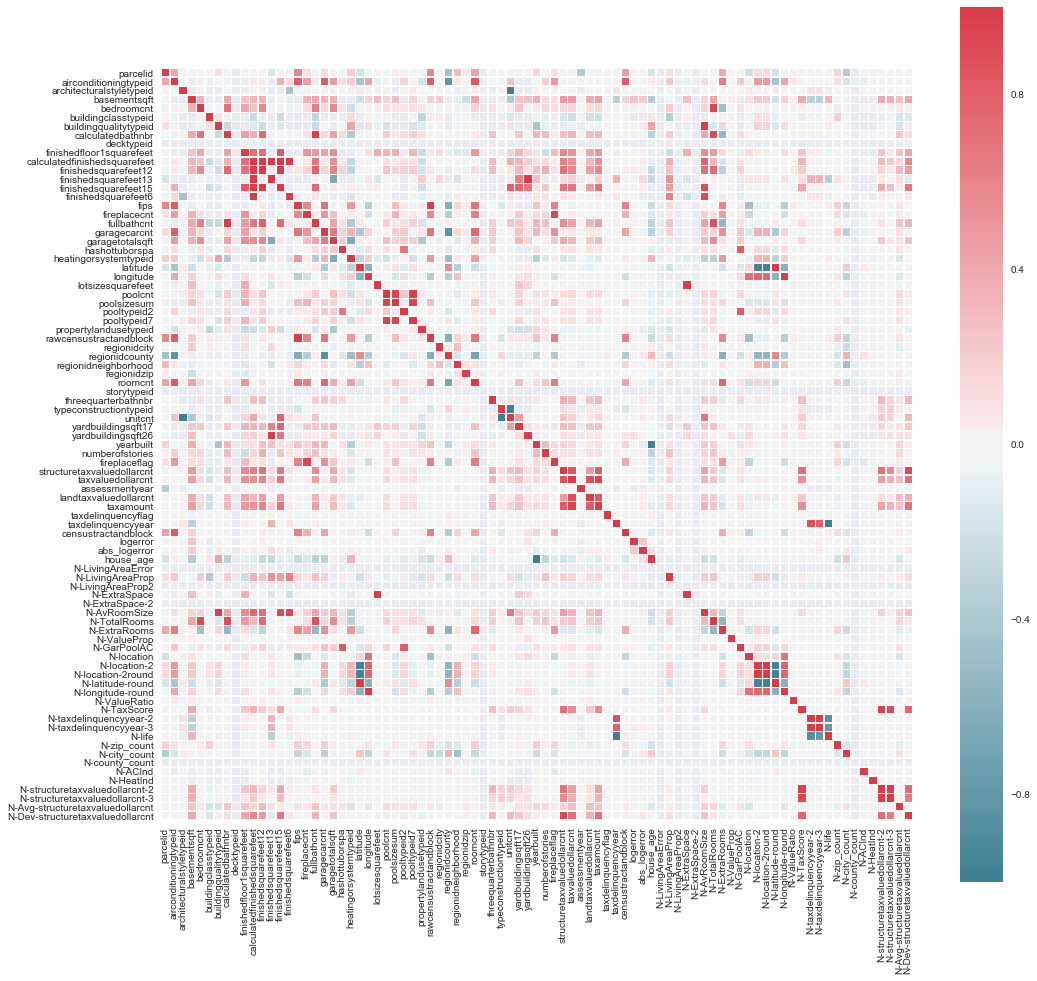

In [140]:
correlation_matrix = properties_df.corr(method = 'pearson')

f, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(correlation_matrix, mask=np.zeros_like(correlation_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, linewidths = 0.5, vmin = -1, vmax = 1)
plt.show()

In [141]:
del correlation_matrix

In [142]:
exog_train = properties_df[properties_df['logerror'].notnull()].drop(['logerror'], axis = 1)
time_series_train = properties_df[properties_df['logerror'].notnull()][['transactiondate', 'logerror']]

exog_train.drop(['parcelid', 'propertyzoningdesc', 'propertycountylandusecode'], axis = 1, inplace = True)

#testX = properties_df[properties_df['logerror'].isnull()].drop(['logerror'], axis = 1)
#testY = properties_df[properties_df['logerror'].isnull()][['parcelid', 'transactiondate', 'logerror']]

In [143]:
exog_train.index = exog_train['transactiondate']
exog_train.drop(['transactiondate'], axis = 1, inplace = True)

time_series_train.index = time_series_train['transactiondate']
time_series_train.drop(['transactiondate'], axis = 1, inplace = True)

In [144]:
gc.collect()

7

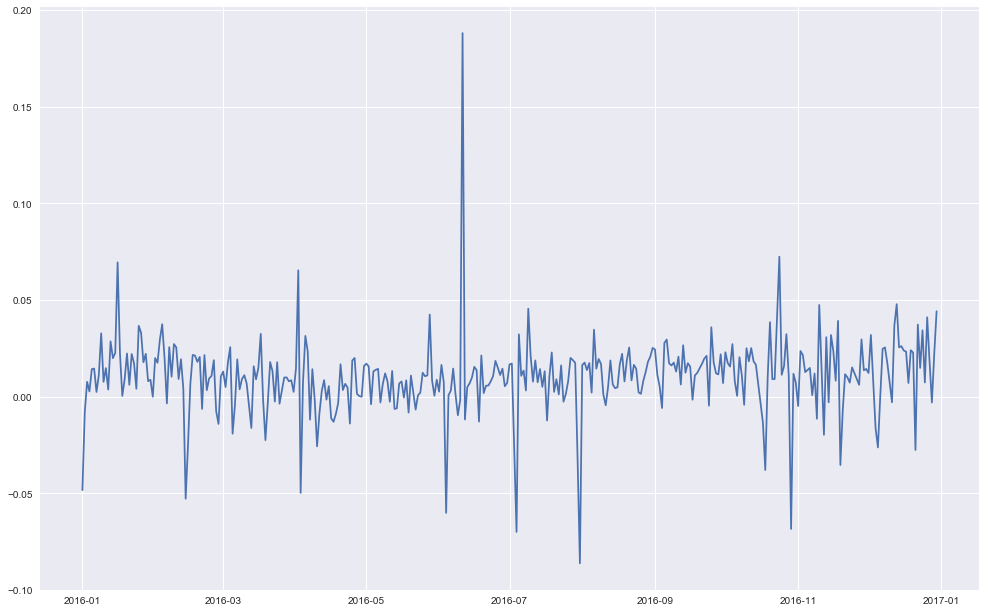

In [145]:
plt.subplots(figsize=(15, 10))
plt.plot(time_series_train.groupby('transactiondate').mean())
plt.show()

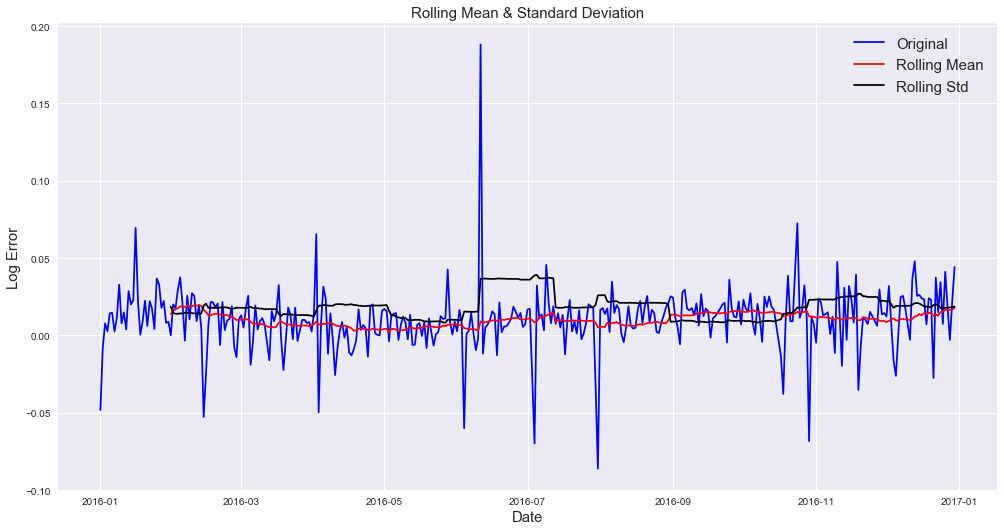

Results of Dickey-Fuller Test:
Test Statistic                -1.841711e+01
p-value                        2.179368e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64


In [146]:
def test_stationarity(timeseries):
    plt.figure(figsize=(15, 8))
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=31) # Slide window depend on past 1 month
    rolstd = pd.rolling_std(timeseries, window=31)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best', fontsize=15)
    plt.title('Rolling Mean & Standard Deviation', fontsize=15)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Log Error', fontsize=15)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['logerror'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(time_series_train.groupby('transactiondate').mean())

In [147]:
# non-stationarity exists

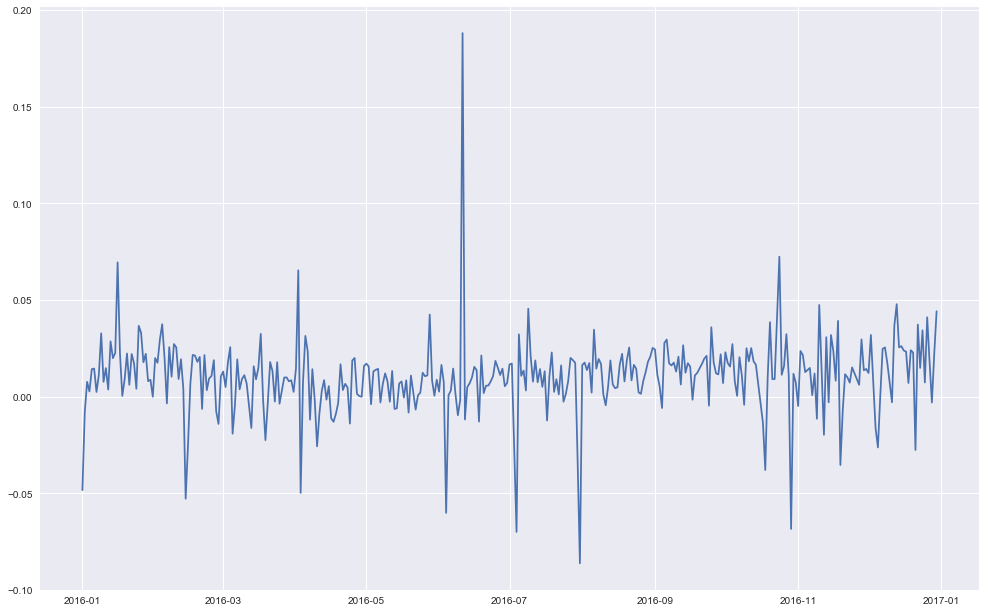

In [148]:
time_series_train_diff = time_series_train
time_series_train_diff_mean = time_series_train_diff.groupby('transactiondate').mean()

plt.subplots(figsize=(15, 10))
plt.plot(time_series_train_diff_mean)
plt.show()

In [149]:
time_series_train_diff_mean.describe()

,logerror
count,352.000000
mean,0.010512
std,0.020151
min,-0.086129
25%,0.002718
50%,0.011269
75%,0.018804
max,0.188100


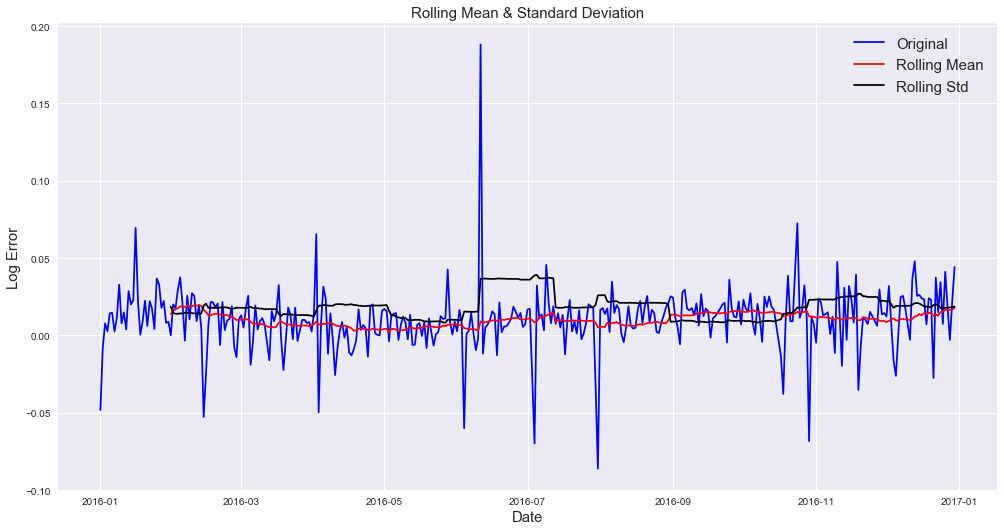

Results of Dickey-Fuller Test:
Test Statistic                -1.841711e+01
p-value                        2.179368e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64


In [150]:
def test_stationarity(timeseries):
    plt.figure(figsize=(15, 8))
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=31) # Slide window depend on past 1 month
    rolstd = pd.rolling_std(timeseries, window=31)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best', fontsize=15)
    plt.title('Rolling Mean & Standard Deviation', fontsize=15)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Log Error', fontsize=15)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['logerror'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(time_series_train_diff_mean)

In [151]:
# Test-statistics is smaller then 1% critical value so we can say time series is stationary with 99% confidence

In [152]:
#making the validation set ready
validation_len = len(time_series_train_diff_mean) - 100

train_timeseries_split, validation_timeseries_split = time_series_train_diff_mean.iloc[0:validation_len], properties_df[['transactiondate', 'logerror']]

validation_timeseries_split = validation_timeseries_split.groupby('transactiondate').mean()

validation_timeseries_split = validation_timeseries_split[validation_len + 1: ]

In [153]:
validation_timeseries_split

,logerror
transactiondate,
2016-09-14,0.012459
2016-09-15,0.017384
2016-09-16,0.015543
2016-09-17,-0.001525
2016-09-18,0.011040
2016-09-19,0.012350
2016-09-20,0.014640
2016-09-21,0.016989
2016-09-22,0.019723


In [154]:
train_timeseries_split

,logerror
transactiondate,
2016-01-01,-0.048267
2016-01-02,-0.008150
2016-01-03,0.007736
2016-01-04,0.002742
2016-01-05,0.014271
2016-01-06,0.014595
2016-01-07,0.002498
2016-01-08,0.011280
2016-01-09,0.032800


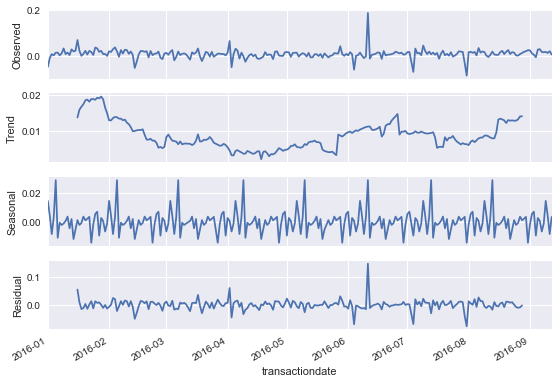

In [155]:
decomposition = sm.tsa.seasonal_decompose(train_timeseries_split, model='additive', freq = 31)
trend = decomposition.trend
seasonal = decomposition.seasonal
#train_residual = decomposition.resid

train_residual = train_timeseries_split

decomposition.plot()
plt.show()

In [156]:
#Not appropriate if negative or zero values exist
#decomposition = sm.tsa.seasonal_decompose(time_series_train_diff_mean, model='multiplicative', freq = 14)
#trend = decomposition.trend
#seasonal = decomposition.seasonal
#residual = decomposition.resid

#decomposition.plot()
#plt.show()

In [157]:
exog_train_mean = exog_train.groupby('transactiondate').mean()

train_exog_split, validation_exog_split = exog_train_mean.iloc[0 : validation_len], exog_train_mean.iloc[validation_len - 1 : ]

train_timeseries_split.shape, train_exog_split.shape, validation_timeseries_split.shape, validation_exog_split.shape

((252, 1), (252, 83), (99, 1), (101, 83))

In [158]:
train_residual.shape

(252, 1)

In [159]:
train_residual[train_residual['logerror'].isnull()]

,logerror
transactiondate,


In [160]:
#backward fill and forward fill
train_residual.ffill(inplace = True)
train_residual.bfill(inplace = True)

In [161]:
train_residual

,logerror
transactiondate,
2016-01-01,-0.048267
2016-01-02,-0.008150
2016-01-03,0.007736
2016-01-04,0.002742
2016-01-05,0.014271
2016-01-06,0.014595
2016-01-07,0.002498
2016-01-08,0.011280
2016-01-09,0.032800


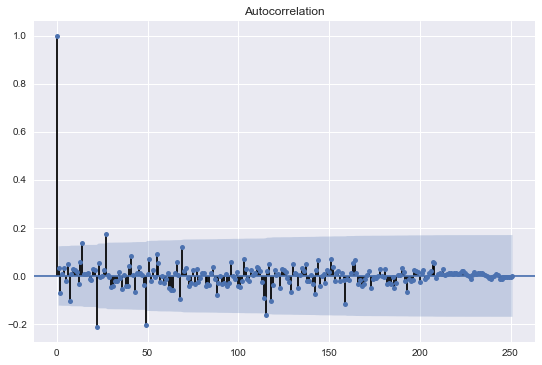

In [162]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_residual)
plt.show()

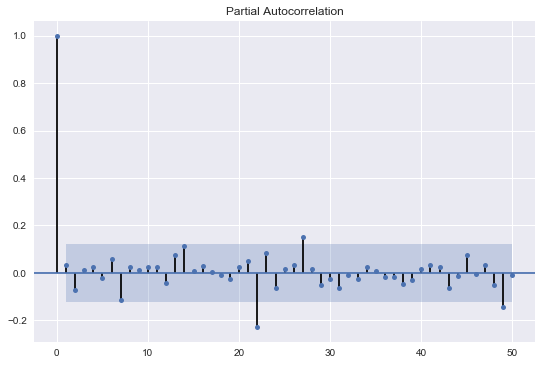

In [163]:

plot_pacf(train_residual, lags = 50)
plt.show()

In [164]:
filled_exog_mean = train_exog_split.fillna(train_exog_split.mean())
filled_validation_exog_split = validation_exog_split.fillna(validation_exog_split.mean())

In [165]:
(len(filled_exog_mean) - filled_exog_mean.count()) > 0

airconditioningtypeid               False
architecturalstyletypeid            False
basementsqft                        False
bedroomcnt                          False
buildingclasstypeid                 False
buildingqualitytypeid               False
calculatedbathnbr                   False
decktypeid                          False
finishedfloor1squarefeet            False
calculatedfinishedsquarefeet        False
finishedsquarefeet12                False
finishedsquarefeet13                False
finishedsquarefeet15                False
finishedsquarefeet6                 False
fips                                False
fireplacecnt                        False
fullbathcnt                         False
garagecarcnt                        False
garagetotalsqft                     False
hashottuborspa                      False
heatingorsystemtypeid               False
latitude                            False
longitude                           False
lotsizesquarefeet                 

In [166]:
#because this column contains so much nan values
filled_exog_mean.drop(['N-county_count', 'N-ExtraSpace-2', 'N-LivingAreaProp2'], axis = 1, inplace = True)

In [167]:
filled_validation_exog_split.drop(['N-county_count', 'N-ExtraSpace-2', 'N-LivingAreaProp2'], axis = 1, inplace = True)

In [168]:
np.where((len(filled_exog_mean) - filled_exog_mean.count()) > 0)

(array([], dtype=int64),)

In [169]:
filled_validation_exog_split.drop(['N-AvRoomSize'], axis = 1, inplace = True)

In [170]:
#because this column contains so much inf values
filled_exog_mean.drop(['N-AvRoomSize'], axis = 1, inplace = True)

In [171]:

#from statsmodels.tsa.arima_model import ARIMA


#arima_model = ARIMA(endog = time_series_train_diff_mean, order = [1, 0, 0], exog = filled_exog_train_mean)



In [172]:
#arima_result = arima_model.fit()

#arima_result
train_residual.shape, filled_exog_mean.shape

((252, 1), (252, 79))

In [173]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [174]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_residual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            exog = filled_exog_mean,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

del results
#look for the lowest AIC

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-1060.0180915081664
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-937.6080022891147
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-1065.513862790538
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-1057.5575219610805
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-917.3045433117368
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-925.0912359763834
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-1124.1676642962923
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-1052.2065128042211
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-919.1832463940859
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-924.4360335606164
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-1063.5467721502316
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-1049.576298226461
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-914.3752010915282
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-914.016940703912
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-900.9070210870436
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-762.0710575197973
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-909.74367990103
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-899.0568

In [175]:
#import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_model = SARIMAX(endog = train_residual,
                                order = (0, 0, 1),
                                exog = filled_exog_mean,
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

sarimax_result = sarimax_model.fit()

In [176]:
print(sarimax_result.summary())

                           Statespace Model Results                           
Dep. Variable:               logerror   No. Observations:                  252
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 649.136
Date:                Mon, 02 Oct 2017   AIC                          -1136.271
Time:                        06:54:53   BIC                           -850.388
Sample:                    01-01-2016   HQIC                         -1021.238
                         - 09-12-2016                                         
Covariance Type:                  opg                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
airconditioningtypeid            -1.021e-07      1e-22  -1.02e+15      0.000   -1.02e-07   -1.02e-07
architecturalstyletypeid         -2.415e-08        nan        nan

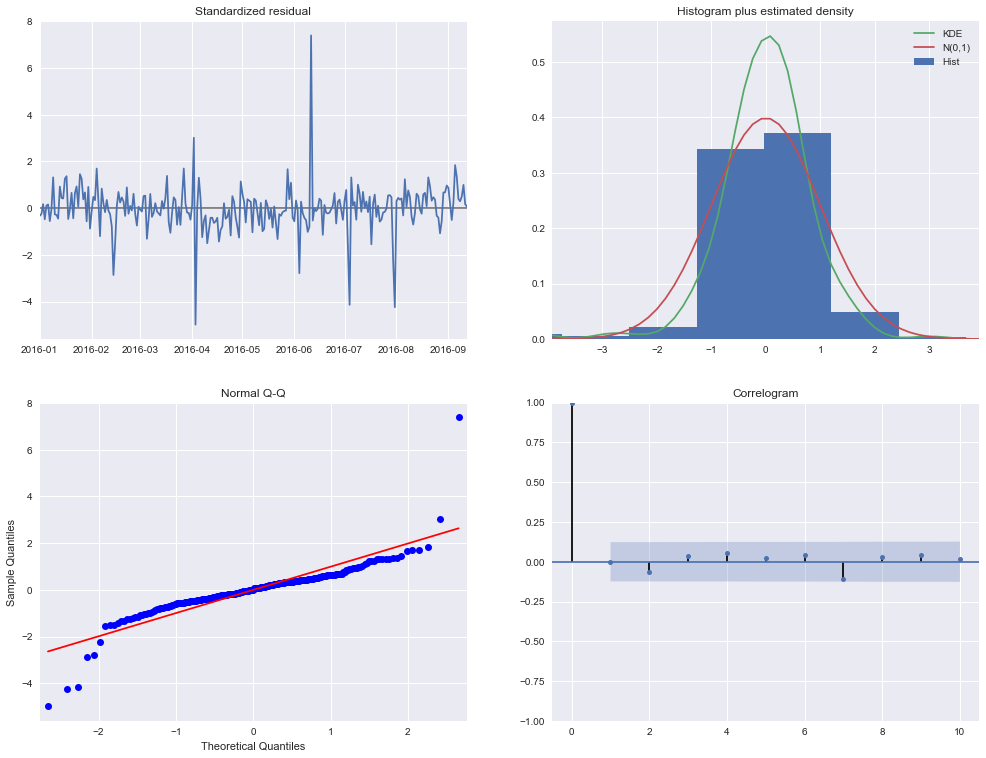

In [177]:
sarimax_result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [178]:
(filled_exog_mean.buildingclasstypeid == np.inf).any()

False

In [179]:
ols_model = sm.OLS(endog = train_residual,exog = filled_exog_mean)

ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     3.487
Date:                Mon, 02 Oct 2017   Prob (F-statistic):           2.09e-05
Time:                        06:54:58   Log-Likelihood:                 649.09
No. Observations:                 252   AIC:                            -1266.
Df Residuals:                     236   BIC:                            -1210.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
airconditioningtypeid            -1.021e-07   7.77e-07     -0.131      0.896   -1.63e-06    1.43e-06
architecturalstyletypeid         -2.415e-08    2.3e-07     -0.105      0.916   -4.77e-07    4.29e-07
basementsqft                      1.201e-07      1e-07      1.195      0.233   -7.79e-08    3.18e-07
bedroomcnt                       -1.385e-10   2.25e-10     -0.615      0.539   -5.82e-10    3.05e-10
buildingclasstypeid               2.976e-13   1.88e-12      0.158      0.875   -3.41e-12    4.01e-12
buildingqualitytypeid             4.508e-10   1.02e-09      0.442      0.659   -1.56e-09    2.46e-09
calculatedbathnbr                -1.646e-09   1.53e-09     -1.075      0.283   -4.66e-09    1.37e-09
decktypeid                       -4.744e-12   5.33e-11     -0.089      0.929    -1.1e-10       1e-10
finishedfloor1squarefeet         -1.517e-07   3.02e-07     -0.502      0.616   -7.47e-07    4.43e-07
calculatedfinishedsquarefeet      2.594e-08   1.68e-07      0.155      0.877   -3.04e-07    3.56e-07
finishedsquarefeet12              3.951e-08   7.44e-08      0.531      0.596   -1.07e-07    1.86e-07
finishedsquarefeet13              5.013e-09   5.55e-09      0.904      0.367   -5.91e-09    1.59e-08
finishedsquarefeet15              1.159e-08   2.54e-07      0.046      0.964   -4.89e-07    5.12e-07
finishedsquarefeet6               1.292e-07   1.61e-06      0.080      0.936   -3.03e-06    3.29e-06
fips                             -8.293e-10   4.49e-09     -0.185      0.853   -9.67e-09    8.01e-09
fireplacecnt                     -3.237e-10    3.4e-09     -0.095      0.924   -7.03e-09    6.38e-09
fullbathcnt                       2.834e-09   2.42e-09      1.171      0.243   -1.94e-09     7.6e-09
garagecarcnt                     -1.004e-10   4.03e-10     -0.249      0.803   -8.94e-10    6.93e-10
garagetotalsqft                  -1.291e-07   3.38e-07     -0.382      0.703   -7.95e-07    5.37e-07
hashottuborspa                   -1.106e-11    3.1e-11     -0.357      0.721   -7.21e-11    4.99e-11
heatingorsystemtypeid             2.556e-09   1.28e-09      1.994      0.047    3.09e-11    5.08e-09
latitude                          2.498e-07    1.3e-06      0.193      0.847    -2.3e-06     2.8e-06
longitude                         6.788e-07   1.34e-06      0.507      0.612   -1.96e-06    3.31e-06
lotsizesquarefeet                 2.972e-06   1.43e-06      2.076      0.039    1.51e-07    5.79e-06
poolcnt                           -2.57e-11   2.83e-10     -0.091      0.928   -5.84e-10    5.32e-10
poolsizesum                      -1.513e-08   4.01e-08     -0.377      0.706   -9.42e-08    6.39e-08
pooltypeid2                      -4.386e-13   2.51e-11     -0.017      0.986   -4.99e-11    4.91e-11
pooltypeid7                      -2.526e-11   2.94e-1

In [180]:
predictions = sarimax_result.get_prediction(start = pd.to_datetime('2016-01-01'), end = pd.to_datetime('2016-09-12'), dynamic=True, full_results=True, exog = filled_exog_mean)

In [181]:
predictions.predicted_mean

transactiondate
2016-01-01   -0.042089
2016-01-02   -0.003651
2016-01-03    0.004481
2016-01-04    0.011671
2016-01-05    0.012033
2016-01-06    0.011744
2016-01-07    0.012859
2016-01-08    0.011734
2016-01-09    0.008361
2016-01-10    0.013187
2016-01-11    0.020102
2016-01-12    0.011982
2016-01-13    0.011338
2016-01-14    0.012223
2016-01-15    0.015186
2016-01-16    0.046344
2016-01-17   -0.002362
2016-01-18    0.009564
2016-01-19    0.009759
2016-01-20    0.010218
2016-01-21    0.014519
2016-01-22    0.009987
2016-01-23    0.000321
2016-01-24    0.003225
2016-01-25    0.009770
2016-01-26    0.010295
2016-01-27    0.011338
2016-01-28    0.009894
2016-01-29    0.018769
2016-01-30   -0.008259
                ...   
2016-08-14   -0.002960
2016-08-15    0.005455
2016-08-16    0.009319
2016-08-17    0.005824
2016-08-18    0.010316
2016-08-19    0.006692
2016-08-20   -0.005602
2016-08-21    0.008531
2016-08-22    0.002896
2016-08-23    0.007956
2016-08-24    0.007865
2016-08-25    0.00

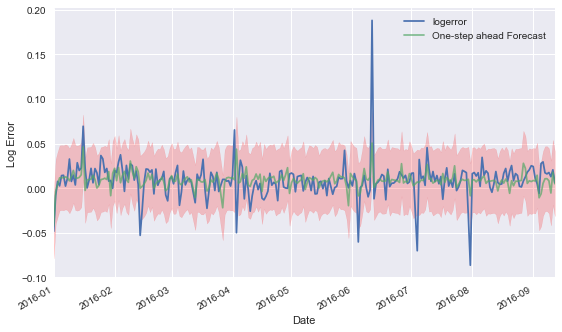

In [182]:
ax = train_residual[0:].plot(label='observed')
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(predictions.conf_int().index,
                predictions.conf_int().iloc[:, 0],
                predictions.conf_int().iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Log Error')
plt.legend()

plt.show()

In [183]:
# Extract the predicted and true values of our time series
from sklearn.metrics import mean_squared_error
from math import sqrt

y_forecasted = predictions.predicted_mean
y_truth = train_residual[0:]

# Compute the mean square error
mse = mean_squared_error(y_truth, y_forecasted)
sqrt(mse)

0.01841313849548615

In [184]:
test = filled_validation_exog_split

In [185]:
test = test.asfreq('d', method = 'bfill')

In [186]:
test = test.ffill()

In [187]:
validation_result = sarimax_result.get_prediction(start = 251, end = 361, dynamic=True, full_results=True, exog = test)

In [188]:
validation_result

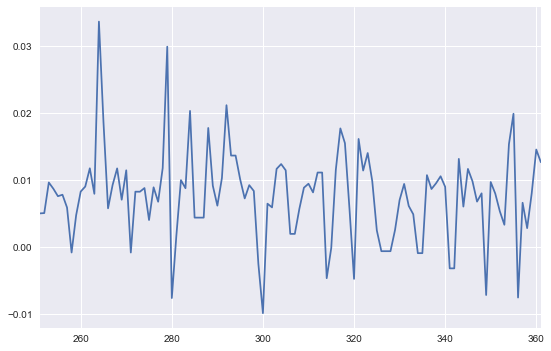

In [190]:
validation_result.predicted_mean.plot()
plt.show()

In [191]:
validation_predictions = pd.DataFrame()

validation_predictions['logerror'] = validation_result.predicted_mean

validation_predictions = validation_predictions.drop(361)

validation_predictions['transactiondate'] = test.index

In [192]:
validation_predictions.index = validation_predictions.transactiondate
validation_predictions.drop(['transactiondate'], axis = 1, inplace = True)
validation_predictions

,logerror
transactiondate,
2016-09-12,0.005007
2016-09-13,0.005056
2016-09-14,0.009626
2016-09-15,0.008690
2016-09-16,0.007577
2016-09-17,0.007796
2016-09-18,0.005884
2016-09-19,-0.000830
2016-09-20,0.004740


In [193]:
validation_result.conf_int()
#validation_predictions.concat(validation_predictions.conf_int())

,lower logerror,upper logerror
251,-0.031333,0.041348
252,-0.031292,0.041403
253,-0.026721,0.045974
254,-0.027658,0.045037
255,-0.028771,0.043924
256,-0.028552,0.044143
257,-0.030464,0.042231
258,-0.037178,0.035517
259,-0.031607,0.041088
260,-0.028081,0.044614


In [194]:
matchingrows_validation = validation_predictions.loc[validation_timeseries_split.index]


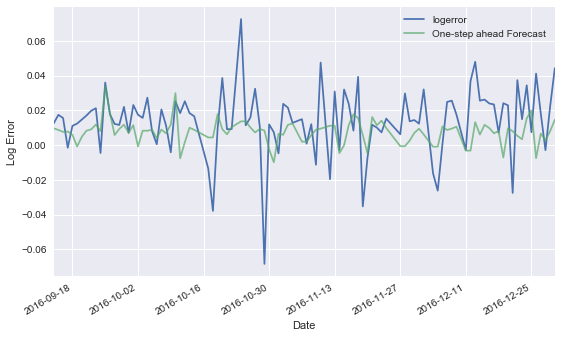

In [195]:
ax = validation_timeseries_split[0:].plot(label='observed')
matchingrows_validation.logerror.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(validation_result.conf_int().index,
                validation_result.conf_int().iloc[:, 0],
                validation_result.conf_int().iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Log Error')
plt.legend()

plt.show()

In [196]:
y_forecasted = matchingrows_validation.logerror
y_truth = validation_timeseries_split[0:]

# Compute the mean square error
mse = mean_squared_error(y_truth, y_forecasted)
sqrt(mse)

0.020071082823612287

In [197]:
test_exog = properties_df[properties_df['logerror'].isnull()]

In [198]:
test_exog.shape

(2895067, 88)

In [204]:
test_exog

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,N-life,N-zip_count,N-city_count,N-county_count,N-ACInd,N-HeatInd,N-structuretaxvaluedollarcnt-2,N-structuretaxvaluedollarcnt-3,N-Avg-structuretaxvaluedollarcnt,N-Dev-structuretaxvaluedollarcnt
0,10754147,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,8497.0,7506.0,NaN,1,1,NaN,NaN,375668.562500,NaN
1,10759547,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,8497.0,7506.0,NaN,1,1,NaN,NaN,375668.562500,NaN
2,10843547,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,9437.0,11686.0,NaN,1,1,4.234834e+11,2.755843e+17,145331.093750,3.477748
3,10859147,NaN,NaN,NaN,0.0,3.0,7.0,0.0,NaN,NaN,...,NaN,7917.0,670951.0,NaN,1,1,3.264363e+11,1.865080e+17,182726.937500,2.126775
4,10879947,NaN,NaN,NaN,0.0,4.0,NaN,0.0,NaN,NaN,...,NaN,7725.0,670951.0,NaN,1,1,3.755689e+10,7.278375e+15,182726.937500,0.060577
5,10898347,NaN,NaN,NaN,0.0,4.0,7.0,0.0,NaN,NaN,...,NaN,5177.0,670951.0,NaN,1,1,3.111096e+10,5.487445e+15,182726.937500,0.034718
6,10933547,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,7258.0,670951.0,NaN,1,1,1.583602e+11,6.301866e+16,182726.937500,1.177812
7,10940747,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,1075.0,24601.0,NaN,1,1,1.040359e+10,1.061146e+15,148057.390625,0.311091
8,10954547,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,6406.0,24601.0,NaN,1,1,NaN,NaN,148057.390625,NaN
9,10976347,NaN,NaN,NaN,0.0,3.0,7.0,0.0,NaN,NaN,...,NaN,6102.0,4354.0,NaN,1,1,4.771603e+10,1.042309e+16,108888.109375,1.006096


In [210]:
test['propertycountylandusecode'].count()

KeyError: 'propertycountylandusecode'